# Credit Default Modeling (Beginner Walkthrough)
We build several simple classifiers to predict whether a credit card customer will default. The dataset comes from the UCI credit card default file (Excel). This notebook favors clear explanations over compact code.
You will see how we connect model predictions to money gained or lost, and we repeat the experiment with a few random seeds to check stability.


## 1. Imports
We load pandas/numpy for data handling, matplotlib/seaborn for charts, and scikit-learn for the models. Everything is imported up front so you can see the full toolbox. (xlrd is pulled automatically when pandas reads the Excel file.)


In [1]:
# Core data wrangling and math helpers
import numpy as np
import pandas as pd

# Plotting libraries for quick visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Path handling and scikit-learn pieces for modeling
from pathlib import Path
from sklearn.base import clone
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    make_scorer,
)

# Make plots look clean and allow wide tables in outputs
sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", 40)


## 2. Load the data
We read the Excel file with the credit card records, rename the target column to `TARGET` (1 = will default, 0 = will pay), and peek at the first rows to sanity check the load.


In [2]:
# Locate the Excel data file. We check two possible paths so the notebook works from different folders.
DATA_FILE = Path("default of credit card clients.xls")
if not DATA_FILE.exists():
    DATA_FILE = Path("Code") / "Final Project" / "default of credit card clients.xls"

# Stop early with a clear message if the file is missing.
if not DATA_FILE.exists():
    raise FileNotFoundError(f"Could not find data file at {DATA_FILE}")

# Read the Excel file.
# header=1 skips the first row of metadata in the UCI file.
# We rename the target column to TARGET to make the code shorter to read.
raw_df = (
    pd.read_excel(DATA_FILE, header=1)
    .rename(columns={"default payment next month": "TARGET"})
)

print(f"Loaded {raw_df.shape[0]:,} rows and {raw_df.shape[1]} columns.")
# Peek at the first few rows to make sure the load worked.
raw_df.head()


Loaded 30,000 rows and 25 columns.


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,TARGET
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 3. Split features and target
We separate the input columns (`X`) from the answer column (`y`). We also print shapes and the number of people who defaulted vs. not.


In [3]:
# Collect every column except the unique ID and the target label.
# Drop the identifier to avoid leaking information that does not generalize.
X = raw_df.drop(columns=["TARGET", "ID"])
feature_cols = X.columns.tolist()
y = raw_df["TARGET"].astype(int)

# Quick sanity checks on shapes and class balance.
print(f"Feature matrix shape: {X.shape}")
print(f"Target breakdown: {y.value_counts().to_dict()}")

# Show the very first rows of X and y so beginners can see the structure.
display(X.head(), y.head())


Feature matrix shape: (30000, 23)
Target breakdown: {0: 23364, 1: 6636}


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


0    1
1    1
2    0
3    0
4    0
Name: TARGET, dtype: int64

## 4. Reusable splits (shared across seeds)
We create train/validation/test splits for several random seeds so each model is trained and evaluated on the exact same partitions. This keeps comparisons fair across all models.


In [4]:
# We will try a few different random seeds to see how stable the results are.
SEED_PLAN = [2025, 0, 1033]
VAL_SEED = 0  # keep the validation split fixed so threshold tuning is comparable
BASELINE_SEED = SEED_PLAN[0]  # this seed will be used for most plots

# Helper function to create train/validation/test splits for one seed.
def build_split_bundle(split_seed, val_seed=VAL_SEED):
    # First split once into train and test (stratified keeps class ratios similar in each split).
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=split_seed,
        stratify=y,
    )

    # Then carve out a validation slice from the training set for threshold tuning.
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.25,
        random_state=val_seed,
        stratify=y_train,
    )

    return {
        "seed": split_seed,
        "X_train_full": X_train,
        "y_train_full": y_train,
        "X_train_sub": X_train_sub,
        "X_val": X_val,
        "X_test": X_test,
        "y_train_sub": y_train_sub,
        "y_val": y_val,
        "y_test": y_test,
    }

# Build and store the splits for each seed in a simple loop (more verbose but clearer for beginners).
split_store = {}
for seed in SEED_PLAN:
    split_store[seed] = build_split_bundle(seed, val_seed=VAL_SEED)

baseline_split = split_store[BASELINE_SEED]

display(
    {
        "seed": BASELINE_SEED,
        "train_sub": baseline_split["X_train_sub"].shape,
        "val": baseline_split["X_val"].shape,
        "test": baseline_split["X_test"].shape,
    }
)


{'seed': 2025, 'train_sub': (18000, 23), 'val': (6000, 23), 'test': (6000, 23)}

## 5. Business assumptions and cost matrix
We translate model outcomes into dollars. Approving a good customer earns interest; approving a bad one loses money. We compute those numbers once on the training data and keep them fixed.


### 5.1 Observation window and APR assumptions
We assume 18% APR, monthly compounding, and only look at six months. Using the average credit limits of good/bad customers, we estimate expected profit from a good approval and expected loss from a bad approval.


In [5]:
baseline_train = split_store[BASELINE_SEED]

# Make a copy so we can add the TARGET column back for easy filtering by default status.
train_full_df = baseline_train["X_train_full"].copy()
train_full_df["TARGET"] = baseline_train["y_train_full"].values

# Compute business parameters only on the training sample to avoid peeking at test (prevents leakage).
# In production, these priors should come from the training split or business-provided assumptions.
# These averages will stay fixed across seeds so the dollar values are comparable.
df_default = train_full_df[train_full_df["TARGET"] == 1]       # customers who will default
df_no_default = train_full_df[train_full_df["TARGET"] == 0]    # customers who will not default

mean_limit_default = df_default["LIMIT_BAL"].mean()
mean_limit_no_default = df_no_default["LIMIT_BAL"].mean()

# Assumptions pulled from the data dictionary PDF.
assumption_config = {
    "annual_apr": 0.18,           # 18% annual percentage rate
    "periods_per_year": 12,       # monthly compounding
    "observation_months": 6,      # we only look at 6 billing cycles
    "loss_given_default": 0.5,    # we expect to lose 50% of the limit if they default
}

# Unpack the assumptions into readable variable names.
annual_apr = assumption_config["annual_apr"]
periods_per_year = assumption_config["periods_per_year"]
observation_months = assumption_config["observation_months"]
loss_given_default = assumption_config["loss_given_default"]

# Translate APR to the window we care about.
periodic_rate = annual_apr / periods_per_year
period_length_months = 12 / periods_per_year
periods_in_window = observation_months / period_length_months

# Expected profit if we APPROVE someone who will pay back.
profit_good = mean_limit_no_default * ((1 + periodic_rate) ** periods_in_window - 1)
# Expected loss if we APPROVE someone who will default.
loss_bad = mean_limit_default * loss_given_default

print(f"Periodic rate: {periodic_rate:.2%}")
print(f"Approx profit per good customer: {profit_good:,.2f}")
print(f"Approx loss per bad customer:    {loss_bad:,.2f}")


Periodic rate: 1.50%
Approx profit per good customer: 16,647.94
Approx loss per bad customer:    65,062.88


### 5.2 Cost/benefit matrix
We build a small table that maps each actual/predicted outcome (TP, FP, TN, FN) to the dollar value from the assumptions. This table powers the utility calculations later.


In [6]:
# Dollar values for each possible outcome.
value_TN = profit_good    # Actual 0, Pred 0: good customer approved -> earn interest
value_FP = 0.0            # Actual 0, Pred 1: good customer rejected -> miss the profit
value_FN = -loss_bad      # Actual 1, Pred 0: bad customer approved -> lose money
value_TP = 0.0            # Actual 1, Pred 1: bad customer rejected -> avoid the loss

# Store them in a small lookup table (rows = actual, columns = predicted).
value_matrix = pd.DataFrame(
    {
        0: {0: value_TN, 1: value_FN},  # Predicted 0
        1: {0: value_FP, 1: value_TP},  # Predicted 1
    }
)
value_matrix.index.name = "Actual"
value_matrix.columns.name = "Predicted"

value_matrix


Predicted,0,1
Actual,,
0,16647.939093,0.0
1,-65062.881899,0.0


## 6. Utility and evaluation helpers
Helper functions to get model scores, sweep decision thresholds, compute utilities, and build tidy summary tables with common metrics (accuracy, precision, recall, ROC AUC, etc.). Each helper is commented for clarity.


In [7]:
CV_FOLDS = 5  # how many folds to use during cross-validation

# Thresholds we will try when turning scores into 0/1 predictions.
THRESH_QUANTILES = np.linspace(0.05, 0.95, 19)


def score_predictions(model, features):
    # Return a continuous score for each row.
    if hasattr(model, "predict_proba"):
        return model.predict_proba(features)[:, 1]
    if hasattr(model, "decision_function"):
        return model.decision_function(features)
    # Fall back to hard class predictions if the model has no scoring method.
    return model.predict(features)


def utility_from_predictions(y_true, y_pred, values=value_matrix):
    # Count true negatives, false positives, false negatives, and true positives.
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    # Multiply each count by its dollar value to get total utility.
    utility_total = (
        tn * values.loc[0, 0]
        + fp * values.loc[0, 1]
        + fn * values.loc[1, 0]
        + tp * values.loc[1, 1]
    )
    # Utility per case lets us compare across datasets of different sizes.
    utility_per_case = utility_total / len(y_true)
    return utility_total, utility_per_case, {"tn": tn, "fp": fp, "fn": fn, "tp": tp}


def _utility(y_true, y_pred):
    # Thin wrapper so we can pass the function around easily.
    return utility_from_predictions(y_true, y_pred, value_matrix)


def sweep_thresholds(y_true, scores, utility_fn, grid=None):
    # Try many thresholds and keep the one that gives the highest utility.
    if grid is None:
        # Use score quantiles so thresholds cover the range evenly.
        grid = np.unique(np.quantile(scores, THRESH_QUANTILES))

    records = []
    for t in grid:
        preds = (scores >= t).astype(int)
        utility_total, utility_pc, _ = utility_fn(y_true, preds)
        records.append(
            {
                "threshold": float(t),
                "utility": utility_total,
                "utility_per_case": utility_pc,
            }
        )

    # Pick the threshold with the largest total utility.
    best = max(records, key=lambda r: r["utility"])
    return {
        "threshold": best["threshold"],
        "val_utility": best["utility"],
        "val_utility_per_case": best["utility_per_case"],
        "sweep": pd.DataFrame(records),
    }


def summarize_model(
    model_name,
    dataset_name,
    y_true,
    y_pred,
    y_score,
    threshold,
    seed,
    utility_fn=_utility,
):
    # Basic classification counts.
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    # Utility and ROC AUC capture the money side and the ranking quality.
    utility_total, utility_pc, _ = utility_fn(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_score) if y_score is not None else np.nan

    total = len(y_pred)
    acceptance_rate = (tn + fn) / total  # predicted 0 = approved
    rejection_rate = (fp + tp) / total   # predicted 1 = rejected

    # Return a one-row DataFrame so everything is easy to stack later.
    return pd.DataFrame(
        [
            {
                "model_name": model_name,
                "dataset_name": dataset_name,
                "seed": seed,
                "threshold": threshold,
                "roc_auc": roc_auc,
                "accuracy": accuracy_score(y_true, y_pred),
                "precision": precision_score(y_true, y_pred, zero_division=0),
                "recall": recall_score(y_true, y_pred, zero_division=0),
                "f1": f1_score(y_true, y_pred, zero_division=0),
                "utility_total": utility_total,
                "utility_per_case": utility_pc,
                "acceptance_rate": acceptance_rate,
                "rejection_rate": rejection_rate,
                "tp": tp,
                "fp": fp,
                "tn": tn,
                "fn": fn,
            }
        ]
    )


def utility_from_scores(y_true, scores):
    # Utility per case using the best threshold on the provided scores.
    sweep = sweep_thresholds(y_true, scores, _utility)
    return sweep["val_utility_per_case"]


# Custom scorer for cross-validation so models are compared on utility, not just accuracy.
utility_scorer = make_scorer(utility_from_scores, needs_threshold=True)


def run_model_for_seed(
    model,
    model_name,
    split_seed,
    threshold_grid=None,
    refit_on_full_train=True,
):
    # Pull the pre-built splits for this seed.
    split = split_store[split_seed]
    X_train = split["X_train_sub"]
    X_val = split["X_val"]
    X_test = split["X_test"]
    y_train = split["y_train_sub"]
    y_val = split["y_val"]
    y_test = split["y_test"]

    # Clone the model so the original is untouched.
    working_model = clone(model)
    working_model.fit(X_train, y_train)

    # Get scores on the validation set and find the best threshold.
    val_scores = score_predictions(working_model, X_val)
    sweep = sweep_thresholds(y_val, val_scores, _utility, grid=threshold_grid)

    # Optionally refit on the full training data before testing.
    final_model = working_model
    if refit_on_full_train:
        final_model = clone(model)
        final_model.fit(split["X_train_full"], split["y_train_full"])

    # Apply the chosen threshold on the test scores.
    test_scores = score_predictions(final_model, X_test)
    test_pred = (test_scores >= sweep["threshold"]).astype(int)

    summary = summarize_model(
        model_name=model_name,
        dataset_name=f"Test (seed={split_seed})",
        y_true=y_test,
        y_pred=test_pred,
        y_score=test_scores,
        threshold=sweep["threshold"],
        seed=split_seed,
    )

    return {
        "seed": split_seed,
        "model_name": model_name,
        "model": final_model,
        "threshold": sweep["threshold"],
        "val_sweep": sweep["sweep"],
        "val_utility": sweep["val_utility"],
        "summary": summary,
        "test_scores": test_scores,
        "test_pred": test_pred,
    }


## 7. Models trained across seeds
For each random seed we fit every model, find the best threshold on the validation fold, then evaluate on the test fold. This gives us comparable rows per seed.


### 7.1 Logistic Regression
Simple linear classifier with L2 regularization. We pick the best `C` (regularization strength) via cross-validation.


In [8]:
# Logistic Regression helper with cross-validation on C to balance regularization strength.
def run_logreg_for_seed(
    split_seed,
    C_grid=(0.01, 0.1, 1.0, 10.0),
    threshold_grid=None,
    cv_folds=CV_FOLDS,
):
    # Pull training data for this seed.
    split = split_store[split_seed]
    X_train = split["X_train_sub"]
    y_train = split["y_train_sub"]

    # Stratified folds keep the class balance similar in each fold.
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=split_seed)
    cv_rows = []
    best_mean = -float("inf")
    best_C = None

    for C in C_grid:
        # Pipeline: scale features then fit logistic regression.
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                penalty="l2",
                solver="liblinear",
                max_iter=500,
                random_state=split_seed,
                class_weight="balanced",
                C=C,
            )),
        ])

        # Evaluate utility with cross-validation.
        scores = cross_val_score(
            pipe,
            X_train,
            y_train,
            cv=cv,
            scoring=utility_scorer,
            n_jobs=-1,
        )
        cv_mean = float(scores.mean())
        cv_std = float(scores.std())
        cv_rows.append({"C": C, "cv_mean_utility": cv_mean, "cv_std_utility": cv_std})

        # Track the best C value. Skip NaN means to avoid leaving best_C as None.
        if not np.isnan(cv_mean) and cv_mean > best_mean:
            best_mean = cv_mean
            best_C = C

    # Fallback in case all cv_mean values were NaN.
    if best_C is None:
        best_C = C_grid[0]

    # Fit the best model on the full training subset.
    best_model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty="l2",
            solver="liblinear",
            max_iter=500,
            random_state=split_seed,
            class_weight="balanced",
            C=best_C,
        )),
    ])

    result = run_model_for_seed(
        best_model,
        model_name="Logistic Regression",
        split_seed=split_seed,
        threshold_grid=threshold_grid,
        refit_on_full_train=True,
    )
    result["cv_results"] = pd.DataFrame(cv_rows)
    result["cv_best_params"] = {"C": best_C, "cv_mean_utility": best_mean}
    return result


In [9]:
# Run logistic regression for every seed and collect the summaries.
logreg_runs = [run_logreg_for_seed(s) for s in SEED_PLAN]

# Combine per-seed results into one table.
logreg_summary_df = pd.concat([r["summary"] for r in logreg_runs], ignore_index=True)
logreg_summary_df


,model_name,dataset_name,seed,threshold,roc_auc,accuracy,precision,recall,f1,utility_total,utility_per_case,acceptance_rate,rejection_rate,tp,fp,tn,fn
0,Logistic Regression,Test (seed=2025),2025,0.525875,0.722673,0.735667,0.428963,0.589299,0.496508,2.500604e+07,4167.674025,0.696167,0.303833,782,1041,3632,545
1,Logistic Regression,Test (seed=0),0,0.544998,0.714441,0.761333,0.465931,0.541070,0.500697,2.447127e+07,4078.545072,0.743167,0.256833,718,823,3850,609
2,Logistic Regression,Test (seed=1033),1033,0.549389,0.713097,0.762667,0.466621,0.510927,0.487770,2.266786e+07,3777.976039,0.757833,0.242167,678,775,3898,649


### 7.2 Decision Tree
Non-linear model that splits the data into rules. We search over tree depth and minimum samples per leaf with cross-validation.


In [10]:

# Decision Tree helper with cross-validation on depth and min_samples_leaf.
def run_dt_for_seed(
    split_seed,
    max_depth_grid=(None, 6, 10, 14),
    min_samples_leaf_grid=(5, 10, 20),
    threshold_grid=None,
    cv_folds=CV_FOLDS,
):
    # Pull training data for this seed.
    split = split_store[split_seed]
    X_train = split["X_train_sub"]
    y_train = split["y_train_sub"]

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=split_seed)
    cv_rows = []
    best_mean = -float("inf")
    best_params = None

    for depth in max_depth_grid:
        for min_leaf in min_samples_leaf_grid:
            model = DecisionTreeClassifier(
                random_state=split_seed,
                max_depth=depth,
                min_samples_leaf=min_leaf,
                class_weight="balanced",
            )
            scores = cross_val_score(
                model,
                X_train,
                y_train,
                cv=cv,
                scoring=utility_scorer,
                n_jobs=-1,
            )
            cv_mean = float(scores.mean())
            cv_std = float(scores.std())
            cv_rows.append(
                {
                    "max_depth": depth,
                    "min_samples_leaf": min_leaf,
                    "cv_mean_utility": cv_mean,
                    "cv_std_utility": cv_std,
                }
            )
            # Ignore NaN scores so we do not leave best_params unset.
            if not np.isnan(cv_mean) and cv_mean > best_mean:
                best_mean = cv_mean
                best_params = {"max_depth": depth, "min_samples_leaf": min_leaf}

    # Fallback in case all cv_mean values were NaN.
    if best_params is None:
        best_params = {
            "max_depth": max_depth_grid[0],
            "min_samples_leaf": min_samples_leaf_grid[0],
        }
        best_mean = np.nan

    best_model = DecisionTreeClassifier(
        random_state=split_seed,
        max_depth=best_params["max_depth"],
        min_samples_leaf=best_params["min_samples_leaf"],
        class_weight="balanced",
    )
    result = run_model_for_seed(
        best_model,
        model_name="Decision Tree",
        split_seed=split_seed,
        threshold_grid=threshold_grid,
        refit_on_full_train=True,
    )
    result["cv_results"] = pd.DataFrame(cv_rows)
    result["cv_best_params"] = {**best_params, "cv_mean_utility": best_mean}
    return result


In [11]:
# Run decision trees for every seed and collect the summaries.
dt_runs = [run_dt_for_seed(s) for s in SEED_PLAN]

dt_summary_df = pd.concat([r["summary"] for r in dt_runs], ignore_index=True)
dt_summary_df


,model_name,dataset_name,seed,threshold,roc_auc,accuracy,precision,recall,f1,utility_total,utility_per_case,acceptance_rate,rejection_rate,tp,fp,tn,fn
0,Decision Tree,Test (seed=2025),2025,0.468109,0.677834,0.679333,0.360839,0.583271,0.445853,1.899172e+07,3165.286866,0.6425,0.3575,774,1371,3302,553
1,Decision Tree,Test (seed=0),0,0.468109,0.661388,0.672167,0.348485,0.554635,0.428031,1.643609e+07,2739.348665,0.6480,0.3520,736,1376,3297,591
2,Decision Tree,Test (seed=1033),1033,0.468109,0.647238,0.661167,0.333804,0.534288,0.410895,1.403012e+07,2338.354092,0.6460,0.3540,709,1415,3258,618


### 7.3 SVM (RBF)
Support Vector Machine with a radial basis function kernel. We tune `C` and `gamma` to balance margin width and flexibility.


In [12]:

# SVM (RBF) helper with cross-validation on C and gamma.
def run_svm_for_seed(
    split_seed,
    C_grid=(0.5, 1.0, 2.0, 5.0),
    gamma_grid=("scale", "auto"),
    threshold_grid=None,
    cv_folds=CV_FOLDS,
):
    # Pull training data for this seed.
    split = split_store[split_seed]
    X_train = split["X_train_sub"]
    y_train = split["y_train_sub"]

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=split_seed)
    cv_rows = []
    best_mean = -float("inf")
    best_params = None

    for C in C_grid:
        for gamma in gamma_grid:
            model = Pipeline([
                ("scaler", StandardScaler()),
                ("clf", SVC(
                    kernel="rbf",
                    C=C,
                    gamma=gamma,
                    probability=False,
                    class_weight="balanced",
                    random_state=split_seed,
                )),
            ])
            scores = cross_val_score(
                model,
                X_train,
                y_train,
                cv=cv,
                scoring=utility_scorer,
                n_jobs=-1,
            )
            cv_mean = float(scores.mean())
            cv_std = float(scores.std())
            cv_rows.append(
                {
                    "C": C,
                    "gamma": gamma,
                    "cv_mean_utility": cv_mean,
                    "cv_std_utility": cv_std,
                }
            )
            # Ignore NaN scores so best_params is always set.
            if not np.isnan(cv_mean) and cv_mean > best_mean:
                best_mean = cv_mean
                best_params = {"C": C, "gamma": gamma}

    # Fallback in case all cv_mean values were NaN.
    if best_params is None:
        best_params = {"C": C_grid[0], "gamma": gamma_grid[0]}
        best_mean = np.nan

    best_model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(
            kernel="rbf",
            C=best_params["C"],
            gamma=best_params["gamma"],
            probability=False,
            class_weight="balanced",
            random_state=split_seed,
        )),
    ])
    result = run_model_for_seed(
        best_model,
        model_name="SVM (RBF)",
        split_seed=split_seed,
        threshold_grid=threshold_grid,
        refit_on_full_train=True,
    )
    result["cv_results"] = pd.DataFrame(cv_rows)
    result["cv_best_params"] = {**best_params, "cv_mean_utility": best_mean}
    return result


In [13]:
# Run SVMs for every seed and collect the summaries.
svm_runs = [run_svm_for_seed(s) for s in SEED_PLAN]

svm_summary_df = pd.concat([r["summary"] for r in svm_runs], ignore_index=True)
svm_summary_df


,model_name,dataset_name,seed,threshold,roc_auc,accuracy,precision,recall,f1,utility_total,utility_per_case,acceptance_rate,rejection_rate,tp,fp,tn,fn
0,SVM (RBF),Test (seed=2025),2025,-0.362265,0.756387,0.742333,0.440907,0.615674,0.513836,2.736648e+07,4561.080786,0.691167,0.308833,817,1036,3637,510
1,SVM (RBF),Test (seed=0),0,0.037092,0.758524,0.776833,0.495924,0.550113,0.521615,2.660051e+07,4433.418014,0.754667,0.245333,730,742,3931,597
2,SVM (RBF),Test (seed=1033),1033,-0.558620,0.756318,0.726167,0.420683,0.631500,0.504971,2.676835e+07,4461.391403,0.668000,0.332000,838,1154,3519,489


### 7.4 Naive Bayes (Gaussian)
Probabilistic model that assumes each feature is normally distributed and independent. We tune the smoothing value.


In [14]:

# Naive Bayes helper with cross-validation on var_smoothing.
def run_nb_for_seed(
    split_seed,
    var_smoothing_grid=(1e-9, 1e-8, 1e-7, 1e-6),
    threshold_grid=None,
    cv_folds=CV_FOLDS,
):
    # Pull training data for this seed.
    split = split_store[split_seed]
    X_train = split["X_train_sub"]
    y_train = split["y_train_sub"]

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=split_seed)
    cv_rows = []
    best_mean = -float("inf")
    best_vs = None

    for vs in var_smoothing_grid:
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", GaussianNB(var_smoothing=vs)),
        ])
        scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring=utility_scorer,
            n_jobs=-1,
        )
        cv_mean = float(scores.mean())
        cv_std = float(scores.std())
        cv_rows.append({"var_smoothing": vs, "cv_mean_utility": cv_mean, "cv_std_utility": cv_std})
        # Skip NaN so best_vs is always set.
        if not np.isnan(cv_mean) and cv_mean > best_mean:
            best_mean = cv_mean
            best_vs = vs

    # Fallback in case all cv_mean values were NaN.
    if best_vs is None:
        best_vs = var_smoothing_grid[0]
        best_mean = np.nan

    best_model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", GaussianNB(var_smoothing=best_vs)),
    ])
    result = run_model_for_seed(
        best_model,
        model_name="Naive Bayes",
        split_seed=split_seed,
        threshold_grid=threshold_grid,
        refit_on_full_train=True,
    )
    result["cv_results"] = pd.DataFrame(cv_rows)
    result["cv_best_params"] = {"var_smoothing": best_vs, "cv_mean_utility": best_mean}
    return result


In [15]:
# Run Naive Bayes for every seed and collect the summaries.
nb_runs = [run_nb_for_seed(s) for s in SEED_PLAN]

nb_summary_df = pd.concat([r["summary"] for r in nb_runs], ignore_index=True)
nb_summary_df


,model_name,dataset_name,seed,threshold,roc_auc,accuracy,precision,recall,f1,utility_total,utility_per_case,acceptance_rate,rejection_rate,tp,fp,tn,fn
0,Naive Bayes,Test (seed=2025),2025,0.671414,0.733645,0.763667,0.471473,0.566692,0.514716,2.635045e+07,4391.741606,0.734167,0.265833,752,843,3830,575
1,Naive Bayes,Test (seed=0),0,0.606108,0.715027,0.654000,0.350975,0.664657,0.459375,2.169005e+07,3615.008046,0.581167,0.418833,882,1631,3042,445
2,Naive Bayes,Test (seed=1033),1033,0.659010,0.735828,0.764667,0.473354,0.568953,0.516769,2.659558e+07,4432.597016,0.734167,0.265833,755,840,3833,572


### 7.5 k-NN
Instance-based classifier that looks at the closest neighbors. We try different numbers of neighbors and keep the one with the best utility.


In [16]:
# k-NN-specific helper to train and evaluate per seed with CV-selected k.
def run_knn_for_seed(
    split_seed,
    k_grid=(5, 10, 15, 20, 25, 30, 35, 40, 45, 50),
    threshold_grid=None,
    cv_folds=CV_FOLDS,
):
    # Pull training data for this seed.
    split = split_store[split_seed]
    X_train = split["X_train_sub"]
    y_train = split["y_train_sub"]

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=split_seed)
    cv_rows = []
    best_mean = -float("inf")
    best_k = None

    for k in k_grid:
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", KNeighborsClassifier(n_neighbors=k, weights="distance")),
        ])
        scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=cv,
            scoring=utility_scorer,
            n_jobs=-1,
        )
        cv_mean = float(scores.mean())
        cv_std = float(scores.std())
        cv_rows.append({"k": k, "cv_mean_utility": cv_mean, "cv_std_utility": cv_std})
        if not np.isnan(cv_mean) and (best_k is None or cv_mean > best_mean):
            best_mean = cv_mean
            best_k = k

    # Fallback in case cross-val produced NaN for every k.
    if best_k is None:
        best_k = k_grid[0]
        best_mean = np.nan

    best_model = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", KNeighborsClassifier(n_neighbors=best_k, weights="distance")),
    ])
    result = run_model_for_seed(
        best_model,
        model_name="k-NN",
        split_seed=split_seed,
        threshold_grid=threshold_grid,
        refit_on_full_train=True,
    )
    result["cv_results"] = pd.DataFrame(cv_rows)
    result["cv_best_params"] = {"k": best_k, "cv_mean_utility": best_mean}
    return result


In [17]:
# Run k-NN for every seed and collect the summaries.
knn_runs = [run_knn_for_seed(s, k_grid=(5, 10, 15, 20, 25, 30, 35, 40, 45, 50)) for s in SEED_PLAN]

knn_summary_df = pd.concat([r["summary"] for r in knn_runs], ignore_index=True)
knn_summary_df


,model_name,dataset_name,seed,threshold,roc_auc,accuracy,precision,recall,f1,utility_total,utility_per_case,acceptance_rate,rejection_rate,tp,fp,tn,fn
0,k-NN,Test (seed=2025),2025,0.280651,0.698635,0.715167,0.394592,0.538809,0.455559,1.971455e+07,3285.757746,0.698000,0.302000,715,1097,3576,612
1,k-NN,Test (seed=0),0,0.284465,0.694384,0.722167,0.402857,0.531274,0.458239,1.992961e+07,3321.601748,0.708333,0.291667,705,1045,3628,622
2,k-NN,Test (seed=1033),1033,0.269581,0.688822,0.715333,0.395157,0.541070,0.456743,1.987644e+07,3312.739874,0.697167,0.302833,718,1099,3574,609


In [18]:
# Bundle model runs and summaries in dictionaries for easy lookups later.
model_runs = {
    "Logistic Regression": logreg_runs,
    "Decision Tree": dt_runs,
    "SVM (RBF)": svm_runs,
    "Naive Bayes": nb_runs,
    "k-NN": knn_runs,
}

model_summary_frames = {
    "Logistic Regression": logreg_summary_df,
    "Decision Tree": dt_summary_df,
    "SVM (RBF)": svm_summary_df,
    "Naive Bayes": nb_summary_df,
    "k-NN": knn_summary_df,
}

# Stack all seed-level summaries into one DataFrame.
combined_model_summaries = pd.concat(model_summary_frames.values(), ignore_index=True)
combined_model_summaries


,model_name,dataset_name,seed,threshold,roc_auc,accuracy,precision,recall,f1,utility_total,utility_per_case,acceptance_rate,rejection_rate,tp,fp,tn,fn
0,Logistic Regression,Test (seed=2025),2025,0.525875,0.722673,0.735667,0.428963,0.589299,0.496508,2.500604e+07,4167.674025,0.696167,0.303833,782,1041,3632,545
1,Logistic Regression,Test (seed=0),0,0.544998,0.714441,0.761333,0.465931,0.541070,0.500697,2.447127e+07,4078.545072,0.743167,0.256833,718,823,3850,609
2,Logistic Regression,Test (seed=1033),1033,0.549389,0.713097,0.762667,0.466621,0.510927,0.487770,2.266786e+07,3777.976039,0.757833,0.242167,678,775,3898,649
3,Decision Tree,Test (seed=2025),2025,0.468109,0.677834,0.679333,0.360839,0.583271,0.445853,1.899172e+07,3165.286866,0.642500,0.357500,774,1371,3302,553
4,Decision Tree,Test (seed=0),0,0.468109,0.661388,0.672167,0.348485,0.554635,0.428031,1.643609e+07,2739.348665,0.648000,0.352000,736,1376,3297,591
5,Decision Tree,Test (seed=1033),1033,0.468109,0.647238,0.661167,0.333804,0.534288,0.410895,1.403012e+07,2338.354092,0.646000,0.354000,709,1415,3258,618
6,SVM (RBF),Test (seed=2025),2025,-0.362265,0.756387,0.742333,0.440907,0.615674,0.513836,2.736648e+07,4561.080786,0.691167,0.308833,817,1036,3637,510
7,SVM (RBF),Test (seed=0),0,0.037092,0.758524,0.776833,0.495924,0.550113,0.521615,2.660051e+07,4433.418014,0.754667,0.245333,730,742,3931,597
8,SVM (RBF),Test (seed=1033),1033,-0.558620,0.756318,0.726167,0.420683,0.631500,0.504971,2.676835e+07,4461.391403,0.668000,0.332000,838,1154,3519,489
9,Naive Bayes,Test (seed=2025),2025,0.671414,0.733645,0.763667,0.471473,0.566692,0.514716,2.635045e+07,4391.741606,0.734167,0.265833,752,843,3830,575


## 8. Summary table (all seeds)
A long table with one row per model per seed plus three simple baselines (random guesses, approve all, reject all). Use this to see how consistent each model is.


In [19]:
baseline_true = baseline_split["y_test"].values

# Helper to reuse summarize_model for baselines that do not produce scores.
def baseline_summary(name, y_pred):
    return summarize_model(
        model_name=name,
        dataset_name="Test (baseline seed)",
        y_true=baseline_true,
        y_pred=y_pred,
        y_score=None,
        threshold=np.nan,
        seed=np.nan,
    )

# Create three simple baselines: random guesses, approve everyone, reject everyone.
rng = np.random.default_rng(0)
baseline_random = baseline_summary("Baseline - Random", rng.integers(0, 2, size=len(baseline_true)))
baseline_approve = baseline_summary("Baseline - Approve all", np.zeros_like(baseline_true))
baseline_reject = baseline_summary("Baseline - Reject all", np.ones_like(baseline_true))

baseline_df = pd.concat([baseline_random, baseline_approve, baseline_reject], ignore_index=True)

# Combine baselines and model results into one big table.
summary_table = pd.concat([baseline_df, combined_model_summaries], ignore_index=True)
summary_table


,model_name,dataset_name,seed,threshold,roc_auc,accuracy,precision,recall,f1,utility_total,utility_per_case,acceptance_rate,rejection_rate,tp,fp,tn,fn
0,Baseline - Random,Test (baseline seed),NaN,NaN,NaN,0.492333,0.214167,0.485305,0.297185,-5.981209e+06,-996.868172,0.498833,0.501167,644,2363,2310,683
1,Baseline - Approve all,Test (baseline seed),NaN,NaN,NaN,0.778833,0.000000,0.000000,0.000000,-8.542625e+06,-1423.770816,1.000000,0.000000,0,0,4673,1327
2,Baseline - Reject all,Test (baseline seed),NaN,NaN,NaN,0.221167,0.221167,1.000000,0.362222,0.000000e+00,0.000000,0.000000,1.000000,1327,4673,0,0
3,Logistic Regression,Test (seed=2025),2025.0,0.525875,0.722673,0.735667,0.428963,0.589299,0.496508,2.500604e+07,4167.674025,0.696167,0.303833,782,1041,3632,545
4,Logistic Regression,Test (seed=0),0.0,0.544998,0.714441,0.761333,0.465931,0.541070,0.500697,2.447127e+07,4078.545072,0.743167,0.256833,718,823,3850,609
5,Logistic Regression,Test (seed=1033),1033.0,0.549389,0.713097,0.762667,0.466621,0.510927,0.487770,2.266786e+07,3777.976039,0.757833,0.242167,678,775,3898,649
6,Decision Tree,Test (seed=2025),2025.0,0.468109,0.677834,0.679333,0.360839,0.583271,0.445853,1.899172e+07,3165.286866,0.642500,0.357500,774,1371,3302,553
7,Decision Tree,Test (seed=0),0.0,0.468109,0.661388,0.672167,0.348485,0.554635,0.428031,1.643609e+07,2739.348665,0.648000,0.352000,736,1376,3297,591
8,Decision Tree,Test (seed=1033),1033.0,0.468109,0.647238,0.661167,0.333804,0.534288,0.410895,1.403012e+07,2338.354092,0.646000,0.354000,709,1415,3258,618
9,SVM (RBF),Test (seed=2025),2025.0,-0.362265,0.756387,0.742333,0.440907,0.615674,0.513836,2.736648e+07,4561.080786,0.691167,0.308833,817,1036,3637,510


## 9. Model comparison summary (baselines + averages)
We average metrics across seeds for every model and line them up next to the baselines so you can spot the overall winner.


In [20]:
# Average metrics across seeds for an easy side-by-side comparison.
def average_rows(df, label):
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    numeric_cols_no_seed = [c for c in numeric_cols if c != "seed"]
    avg_row = df[numeric_cols_no_seed].mean().to_frame().T
    avg_row["model_name"] = f"{label} (avg seeds)"
    avg_row["dataset_name"] = "Test (avg seeds)"
    cols = [c for c in df.columns if c != "seed"]
    return avg_row.reindex(columns=cols)

avg_rows = [
    average_rows(logreg_summary_df, "Logistic Regression"),
    average_rows(dt_summary_df, "Decision Tree"),
    average_rows(svm_summary_df, "SVM (RBF)"),
    average_rows(nb_summary_df, "Naive Bayes"),
    average_rows(knn_summary_df, "k-NN"),
]

comparison_df = pd.concat([baseline_df] + avg_rows, ignore_index=True)
comparison_df


,model_name,dataset_name,seed,threshold,roc_auc,accuracy,precision,recall,f1,utility_total,utility_per_case,acceptance_rate,rejection_rate,tp,fp,tn,fn
0,Baseline - Random,Test (baseline seed),NaN,NaN,NaN,0.492333,0.214167,0.485305,0.297185,-5.981209e+06,-996.868172,0.498833,0.501167,644.000000,2363.000000,2310.000000,683.000000
1,Baseline - Approve all,Test (baseline seed),NaN,NaN,NaN,0.778833,0.000000,0.000000,0.000000,-8.542625e+06,-1423.770816,1.000000,0.000000,0.000000,0.000000,4673.000000,1327.000000
2,Baseline - Reject all,Test (baseline seed),NaN,NaN,NaN,0.221167,0.221167,1.000000,0.362222,0.000000e+00,0.000000,0.000000,1.000000,1327.000000,4673.000000,0.000000,0.000000
3,Logistic Regression (avg seeds),Test (avg seeds),NaN,0.540087,0.716737,0.753222,0.453838,0.547099,0.494992,2.404839e+07,4008.065045,0.732389,0.267611,726.000000,879.666667,3793.333333,601.000000
4,Decision Tree (avg seeds),Test (avg seeds),NaN,0.468109,0.662153,0.670889,0.347709,0.557398,0.428260,1.648598e+07,2747.663207,0.645500,0.354500,739.666667,1387.333333,3285.666667,587.333333
5,SVM (RBF) (avg seeds),Test (avg seeds),NaN,-0.294598,0.757076,0.748444,0.452504,0.599096,0.513474,2.691178e+07,4485.296734,0.704611,0.295389,795.000000,977.333333,3695.666667,532.000000
6,Naive Bayes (avg seeds),Test (avg seeds),NaN,0.645510,0.728167,0.727444,0.431934,0.600100,0.496953,2.487869e+07,4146.448889,0.683167,0.316833,796.333333,1104.666667,3568.333333,530.666667
7,k-NN (avg seeds),Test (avg seeds),NaN,0.278233,0.693947,0.717556,0.397535,0.537051,0.456847,1.984020e+07,3306.699789,0.701167,0.298833,712.666667,1080.333333,3592.666667,614.333333


## 10. Multi-model visualizations
Bar chart of utility per case by seed, ROC curves for the baseline seed, and a confusion matrix for the top average-utility model.


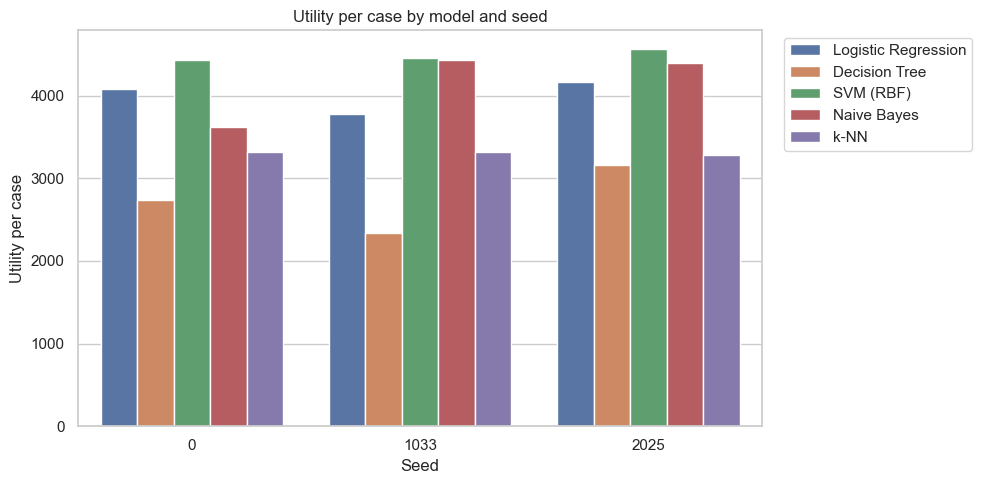

In [21]:
# Utility per case for each model and seed.
plot_data = combined_model_summaries.copy()
plot_data["seed"] = plot_data["seed"].astype(int)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(data=plot_data, x="seed", y="utility_per_case", hue="model_name", ax=ax)
ax.set_title("Utility per case by model and seed")
ax.set_xlabel("Seed")
ax.set_ylabel("Utility per case")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()


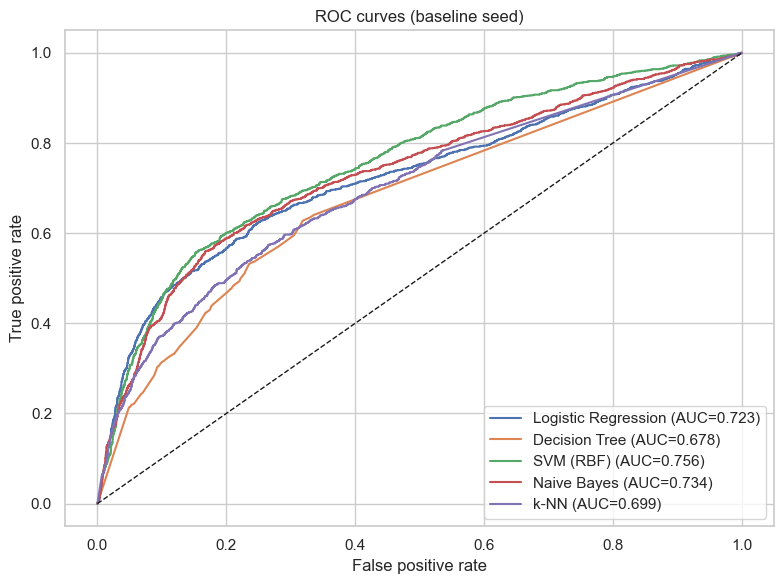

In [22]:
# ROC curves for each model using the baseline seed only.
baseline_y_true = baseline_split["y_test"].values

fig, ax = plt.subplots(figsize=(8, 6))
for name, runs in model_runs.items():
    baseline_run = next(r for r in runs if r["seed"] == BASELINE_SEED)
    fpr, tpr, _ = roc_curve(baseline_y_true, baseline_run["test_scores"])
    auc_val = baseline_run["summary"]["roc_auc"].iloc[0]
    ax.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.3f})")

ax.plot([0, 1], [0, 1], "k--", linewidth=1)
ax.set_title("ROC curves (baseline seed)")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.legend(loc="lower right")
plt.tight_layout()


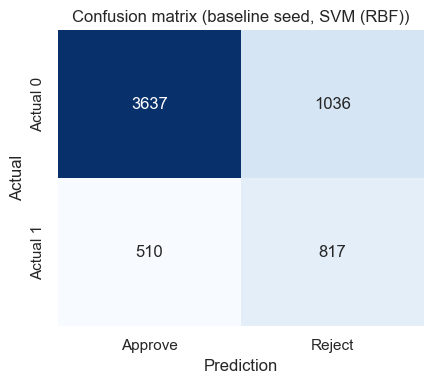

In [23]:
# Confusion matrix for the top model (by average utility) on the baseline seed.
avg_util = combined_model_summaries.groupby("model_name")["utility_per_case"].mean().sort_values(ascending=False)
top_model_name = avg_util.index[0]
top_run = next(r for r in model_runs[top_model_name] if r["seed"] == BASELINE_SEED)

cm = confusion_matrix(baseline_y_true, top_run["test_pred"], labels=[0, 1])
fig, ax = plt.subplots(figsize=(4.5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    ax=ax,
    xticklabels=["Approve", "Reject"],
    yticklabels=["Actual 0", "Actual 1"],
)
ax.set_title(f"Confusion matrix (baseline seed, {top_model_name})")
ax.set_xlabel("Prediction")
ax.set_ylabel("Actual")
plt.tight_layout()
